In [1]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt 
import pickle


from synthetic_signal import SignalGenerator

from sklearn.model_selection import ParameterGrid
#from experiment import ExperimentSampleEvent

from methods import BasePersistentPattern
from competitors import Baseline,LatentMotif,MatrixProfile,Valmod,PanMatrixProfile

# Experiment Parameters

In [2]:
def get_trial(experiment_name,folder_path):
    lst = os.listdir(folder_path)
    lst_idx = []
    if len(lst)>0:
        for filename in lst: 
            if experiment_name in filename: 
                idx = filename.split("_")[-1].split(".")[0]
                lst_idx.append(int(idx))
        if len(lst_idx)>0:
            return np.max(lst_idx) + 1
    return 0 

In [3]:
N_SIGNALS = 1
SCENARIO = "variable_length_motif"

RESULT_FOLDER = Path("./Results/Synthetic/")
TRIAL = get_trial(SCENARIO,RESULT_FOLDER)
BACKUP_PATH = f'./Results/Synthetic/{SCENARIO}_{TRIAL}.csv'
EXPERIMENT_PATH = f'./Results/Synthetic/{SCENARIO}_{TRIAL}.pickle'

In [4]:
SCENARII = {
    "default" : dict(
        n_motifs = 5,
        motif_length=100,
        motif_amplitude=1,
        motif_fundamental =4,
        motif_type ='Sin',
        noise_amplitude=0.1,
        n_novelties=0,
        sparsity=0.25,
        sparsity_fluctuation = 0.2,
        walk_amplitude = 0.1,
        min_rep=5,
        max_rep=5
    ),
    "equal_length_motif" : dict(
        n_motifs = 3,
        motif_length=100,
        motif_amplitude=1,
        motif_fundamental =4,
        motif_type ='Sin',
        noise_amplitude=0.1,
        n_novelties=0,
        sparsity=3,
        sparsity_fluctuation = 0.2,
        min_rep=2,
        max_rep=10
    ),
    "variable_length_motif" : dict(
        n_motifs = 5,
        motif_length=(100,150),
        motif_amplitude=1,
        motif_fundamental =4,
        motif_type ='Sin',
        noise_amplitude=0.1,
        n_novelties=0,
        sparsity=3,
        sparsity_fluctuation = 0.2,
        walk_amplitude = 0.1,
        min_rep=2,
        max_rep=2,
    ),
}

# Dataset

In [5]:
#SCENARII = dict(
#    n_motifs = [3],
#    motif_length=[100],
#    motif_amplitude=[1],
#    motif_fundamental =[1],
#    motif_type =['Sin'],
#    noise_amplitude=[0.1],
#    n_novelties=[0,1],
#    sparsity=[0.5],
#    sparsity_fluctuation = [0.2],
#    walk_amplitude = [0.1],
#    min_rep=[2],
#    max_rep=[5]
#)

In [6]:
#n_signals= 11
#config_lst = ParameterGrid(SCENARII)
def generate_dataset(config_lst:list,n_signals:int)->tuple:
    """Generate a dataset

    Args:
        config_lst (list): list of dictionnary, each dictionnary is a configuration
        n_signals (int): the number of signals is evenly distributed among all configurations

    Returns:
        tuple: list of signals, associated labels, associated configurations
    """
    df = pd.DataFrame.from_dict(config_lst)
    n_configs = df.shape[0]
    n_sig_config = np.ceil(n_signals/n_configs).astype(int)
    idxs = np.repeat(np.arange(n_configs),n_sig_config)
    df = df.loc[idxs]
    df = df.reset_index(drop=True)

    configs = df.to_dict(orient="records")
    dataset = []
    labels = []
    for i,config in enumerate(configs): 
        np.random.seed(i)
        signal, label = SignalGenerator(**config).generate()
        dataset.append(signal)
        labels.append(label)
    return dataset,labels,df


In [7]:
import time

from metric import SingleSampleScore,SampleScore,SingleEventScore,EventScore,AdjustedMutualInfoScore
from synthetic_signal import SignalGenerator

In [8]:
class ExperimentSampleEvent(object): 

    def __init__(self,algorithms:list, configurations:list, nbins = 101) -> None:
        """Initialization

        Args:
            algorithms (list): list of algorithm classes
            configurations (list): list of list of configurations as dictionnaries for each algorithms classes
            nbins (int, optional): number of bins for thresholdings. Defaults to 101.
        """
        self.algorithms = algorithms
        self.configurations = configurations
        self.nbins = nbins

    def _get_algo_class_predictions(self,signal:np.ndarray,algo_class:object, configs:dict)->np.ndarray: 
        """Get predictions for one signal one algorithm and all its configurations

        Args:
            signal (np.ndarray): signal, shape: (L,)
            algo_class (object): algortihm class
            configs (dict): list of algorithm configurations

        Returns:
            np.ndarray: predictions, exectution times
        """
        predictions = []
        execution_time = []
        for config in configs:
            algo = algo_class(**config)
            start = time.time()
            algo.fit(signal)
            end = time.time()
            predictions.append(algo.prediction_mask_)
            execution_time.append(end-start)

        return np.array(predictions),np.array(execution_time)

    def _compute_single_sample_score(self,single_label:np.ndarray,single_preds:np.ndarray)->list:
        """Compute single sample score

        Args:
            single_label (np.ndarray): label, shape: (L,)
            single_preds (np.ndarray): prediction, shape: (L,)

        Returns:
            list: score
        """
        sss = SingleSampleScore() 
        sss_scores = []
        for single_pred in single_preds: 
            sss_scores.append(sss.score(single_label,single_pred))
        sss_scores = np.array(sss_scores)
        n_configs = sss_scores.shape[0]
        score = np.hstack((np.full((n_configs,1),'sss'),np.full((n_configs,1),np.nan),np.arange(n_configs).reshape(-1,1),np.full((n_configs,1),np.nan),sss_scores))
        return score

    def _compute_sample_score(self,label:np.ndarray,predictions:np.ndarray)->list: 
        """Compute sampling score

        Args:
            label (np.ndarray): label, shape (N,L)
            predictions (np.ndarray): prediction, shape (N,L)

        Returns:
            list: score
        """
        ss = SampleScore()
        ss_scores = []
        for prediction in predictions: 
            ss_scores.append(ss.score(label,prediction))
        ss_scores = np.array(ss_scores)
        n_configs = ss_scores.shape[0]
        score = np.hstack((np.full((n_configs,1),'ss'),np.full((n_configs,1),np.nan),np.arange(n_configs).reshape(-1,1),np.full((n_configs,1),np.nan),ss_scores))
        return score

    def _compute_single_event_score(self,single_label:np.ndarray,single_preds:np.ndarray)->np.ndarray: 
        """Compute single event score

        Args:
            single_label (np.ndarray): label, shape: (L,)
            single_preds (np.ndarray): prediction, shape: (L,)

        Returns:
            np.ndarray: score
        """
        ses = SingleEventScore(self.nbins)
        thresholds = np.linspace(0,1,self.nbins)

        #compute scores
        scores = []
        for idx,single_pred in enumerate(single_preds): 
            t_scores = np.array(ses.all_score(single_label,single_pred)).T
            mean_score = np.mean(t_scores,axis=0)
            auc_score = np.array(['ses_auc', np.nan, idx, np.nan] + mean_score.tolist()).reshape(1,-1)
            t_scores = np.hstack((np.full((self.nbins,1),'ses'),thresholds.reshape(-1,1),np.full((self.nbins,1),idx),np.full((self.nbins,1),np.nan),t_scores))
            t_scores = np.vstack((auc_score,t_scores))
            scores.append(t_scores)
        scores = np.array(scores)
        scores = np.vstack((scores))
        return scores

    
    def _compute_event_score(self,label:np.ndarray,predictions:np.ndarray)->np.ndarray:
        """Compute event score

        Args:
            label (np.ndarray): label, shape (N,L)
            predictions (np.ndarray): prediction, shape (N,L)

        Returns:
            np.ndarray: score
        """ 
        es = EventScore(self.nbins)
        thresholds = np.linspace(0,1,self.nbins)

        #compute scores
        scores = []
        for idx,prediction in enumerate(predictions): 
            t_scores = np.array(es.all_score(label,prediction)).T
            mean_score = np.mean(t_scores,axis=0)
            auc_score = np.array(['es_auc', np.nan, idx,np.nan] + mean_score.tolist()).reshape(1,-1)
            t_scores = np.hstack((np.full((self.nbins,1),'es'),thresholds.reshape(-1,1),np.full((self.nbins,1),idx),np.full((self.nbins,1),np.nan),t_scores))
            t_scores = np.vstack((auc_score,t_scores))
            scores.append(t_scores)
        scores = np.array(scores)
        scores = np.vstack((scores))
        return scores
    

    def _compute_adjusted_mutual_info_score(self,label:np.ndarray,predictions:np.ndarray)->np.ndarray:
        """Compute adjusted mutual info score

        Args:
            label (np.ndarray): label, shape (N,L)
            predictions (np.ndarray): prediction, shape (N,L)

        Returns:
            np.ndarray: score
        """ 
        amis = AdjustedMutualInfoScore()
        amis_scores = []
        for prediction in predictions: 
            amis_scores.append([amis.score(label,prediction),np.nan,np.nan,np.nan])
        amis_scores = np.array(amis_scores)
        n_configs = amis_scores.shape[0]
        score = np.hstack((np.full((n_configs,1),'amis'),np.full((n_configs,1),np.nan),np.arange(n_configs).reshape(-1,1),amis_scores))
        return score



    def _compute_scores(self,label:np.ndarray,predictions:np.ndarray)->np.ndarray: 
        """Compute score

        Args:
            label (np.ndarray): label, shape (N,L)
            predictions (np.ndarray): prediction, shape (N,L)

        Returns:
            np.ndarray: score
        """
        scores = []

        single_preds = np.clip(np.sum(predictions,axis=1),0,1) 
        single_label = np.clip(np.sum(label,axis=0),0,1)

        #single sample score
        sss_score = self._compute_single_sample_score(single_label,single_preds) 
        scores.append(sss_score)

        #sample score
        ss_score = self._compute_sample_score(label,predictions)
        scores.append(ss_score)

        #single event score 
        ses_score = self._compute_single_event_score(single_label,single_preds)
        scores.append(ses_score)

        #event score
        es_score = self._compute_event_score(label,predictions)
        scores.append(es_score)

        #amis score 
        amis_score = self._compute_adjusted_mutual_info_score(label,predictions)
        scores.append(amis_score)

        scores = np.vstack(scores)

        return scores            

    def run_experiment(self,dataset:np.ndarray,labels:np.ndarray,signal_configs=None,backup_path = None,verbose = True)->np.ndarray:
        """_summary_

        Args:
            dataset (np.ndarray): array of signals, signal shape (L,), variable length allowed
            labels (np.ndarray): array of labels, label shape (L,), variable length allowed
            signal_configs (pd.DataFrame, optional): Dataframe containing the configuration of the synthetic generator for each signals.
            backup_path (str, optional): Path to store df in case of big experiment. If None no saving. Defaults to None.
            verbose (bool, optional): verbose. Defaults to True.

        Returns:
            pd.DataFrame: scores_df
        """
        if signal_configs: 
            self.signal_configs_ = signal_configs
        
        n_signals = len(dataset)
        n_configs = np.sum([len(conf) for conf in self.configurations])
        total = n_signals*n_configs

        self.df_ = pd.DataFrame()

        counter = 0
        for s_idx,(signal,label) in enumerate(zip(dataset,labels)): 
            for algo_class,configs in zip(self.algorithms,self.configurations): 
                predictions,execution_times = self._get_algo_class_predictions(signal,algo_class,configs)
                scores = self._compute_scores(label,predictions)
                t_df = pd.DataFrame(scores, columns=['metric', 'threshold', 'config_idx', 'score', 'precision', 'recall', 'f1-score'])
                t_df['algorithm'] = algo_class.__name__
                t_df['signal_idx'] = s_idx
                t_df = t_df.astype({'config_idx' : int})
                other = pd.DataFrame({'ex_time' : execution_times})
                t_df = t_df.join(other=other, on='config_idx')
                self.df_= pd.concat((self.df_,t_df)).reset_index(drop = True)
                self.df_ = self.df_.astype({'metric':str, 'threshold':float, 'config_idx':int, "score":float ,'precision':float, 'recall':float, 'f1-score':float})

                ss_score = scores[scores[:,0] == "ss"]
                best_config = np.argmax(ss_score[:,-1])
                ss_scores = ss_score[best_config]
                amis_score = scores[scores[:,0] == "amis"]
                best_config = np.argmax(ss_score[:,-1])
                amis_scores = amis_score[best_config]
                counter += len(configs)
                if verbose: 
                    print(f"Prog: {np.around(100*counter/total,2)}%, signal: {s_idx+1}/{n_signals}, algo: {algo_class.__name__}, amis : {np.around(float(amis_scores[3]),2)}, ss_precision: {np.around(float(ss_scores[4]),2)}, ss_recall: {np.around(float(ss_scores[5]),2)}, ss_f1_score: {np.around(float(ss_scores[6]),2)}")
        
            if backup_path != None: 
                self.df_.to_csv(backup_path)

        return self.df_

In [9]:
sg = SignalGenerator(**SCENARII[SCENARIO])
sg.generate()
sg.plot()

In [10]:
dataset = []
labels = []
for i in range(N_SIGNALS): 
    np.random.seed(i)
    signal, label = sg.generate()
    dataset.append(signal)
    labels.append(label)

# Algorithm Configuration

In [11]:
configs_bpp = ParameterGrid(dict(n_patterns = [3] ,n_neighbors = [2],wlen = [100],alpha = [10], beta = [0],n_jobs = [4]))
configs_bl = ParameterGrid(dict(n_patterns = [3] ,radius = np.linspace(5,10,10),wlen = [100],distance_name = ['NormalizedEuclidean'],n_jobs = [4]))
#configs_lm = ParameterGrid(dict(n_patterns = [3] ,radius = np.linspace(10,15,10),wlen = [100], learning_rate = [0.1]))
configs_mp = ParameterGrid(dict(n_patterns = [3] ,radius_ratio = np.linspace(1,5,15),wlen = [150],distance_name = ['NormalizedEuclidean'],n_jobs = [4]))
configs_vm = ParameterGrid(dict(n_patterns = [3] ,radius_ratio = np.linspace(1,5,10),min_wlen = [int(100*0.95)], max_wlen = [int(100*1.05)],distance_name = ['NormalizedEuclidean'],n_jobs = [4]))

In [12]:
algorithms = [
    BasePersistentPattern,
    Baseline,
    #LatentMotif,
    MatrixProfile,
    Valmod,
]

configurations = [
    configs_bpp,
    configs_bl, 
    #configs_lm, 
    configs_mp, 
    configs_vm, 
]

# Experiment

In [13]:
ese = ExperimentSampleEvent(algorithms,configurations)
ese.run_experiment(dataset,labels,BACKUP_PATH)
with open(EXPERIMENT_PATH, 'wb') as filehandler: 
    pickle.dump(ese,filehandler)

Prog: 2.78%, signal: 1/1, algo: BasePersistentPattern, amis : 0.39, ss_precision: 0.22, ss_recall: 0.6, ss_f1_score: 0.32
Prog: 30.56%, signal: 1/1, algo: Baseline, amis : 0.16, ss_precision: 0.09, ss_recall: 0.43, ss_f1_score: 0.16
Prog: 72.22%, signal: 1/1, algo: MatrixProfile, amis : 0.37, ss_precision: 0.23, ss_recall: 0.47, ss_f1_score: 0.3


/Users/tgermain/Documents/code/Persistent Pattern Discovery/competitors.py:957: RuntimeWarning:

invalid value encountered in cast



Prog: 100.0%, signal: 1/1, algo: Valmod, amis : 0.45, ss_precision: 0.54, ss_recall: 0.43, ss_f1_score: 0.48


In [14]:
df = ese.df_

In [15]:
df.shape

(7452, 10)

In [16]:
t_df = df[df['metric'].isin(['ss', 'sss', 'es_auc', 'ses_auc'])].groupby(['metric','algorithm']).mean()
t_df[['precision','recall','f1-score']]

precision    recall  f1-score
metric  algorithm                                           
es_auc  BasePersistentPattern   0.214851  0.600000  0.230891
        Baseline                0.066452  0.363564  0.092627
        MatrixProfile           0.211680  0.460462  0.252004
        Valmod                  0.130055  0.313465  0.134197
ses_auc BasePersistentPattern   0.417492  0.902970  0.473562
        Baseline                0.287144  0.683960  0.368923
        MatrixProfile           0.410784  0.792013  0.489780
        Valmod                  0.338822  0.726238  0.411244
ss      BasePersistentPattern   0.224102  0.598529  0.316331
        Baseline                0.068575  0.377097  0.114802
        MatrixProfile           0.213782  0.471301  0.276153
        Valmod                  0.132555  0.310623  0.161189
sss     BasePersistentPattern   0.486874  0.998369  0.654545
        Baseline                0.358580  0.765742  0.480198
        MatrixProfile           0.425736  0.812289  0.535689
        Valmod                  0.398476  0.839560  0.500726

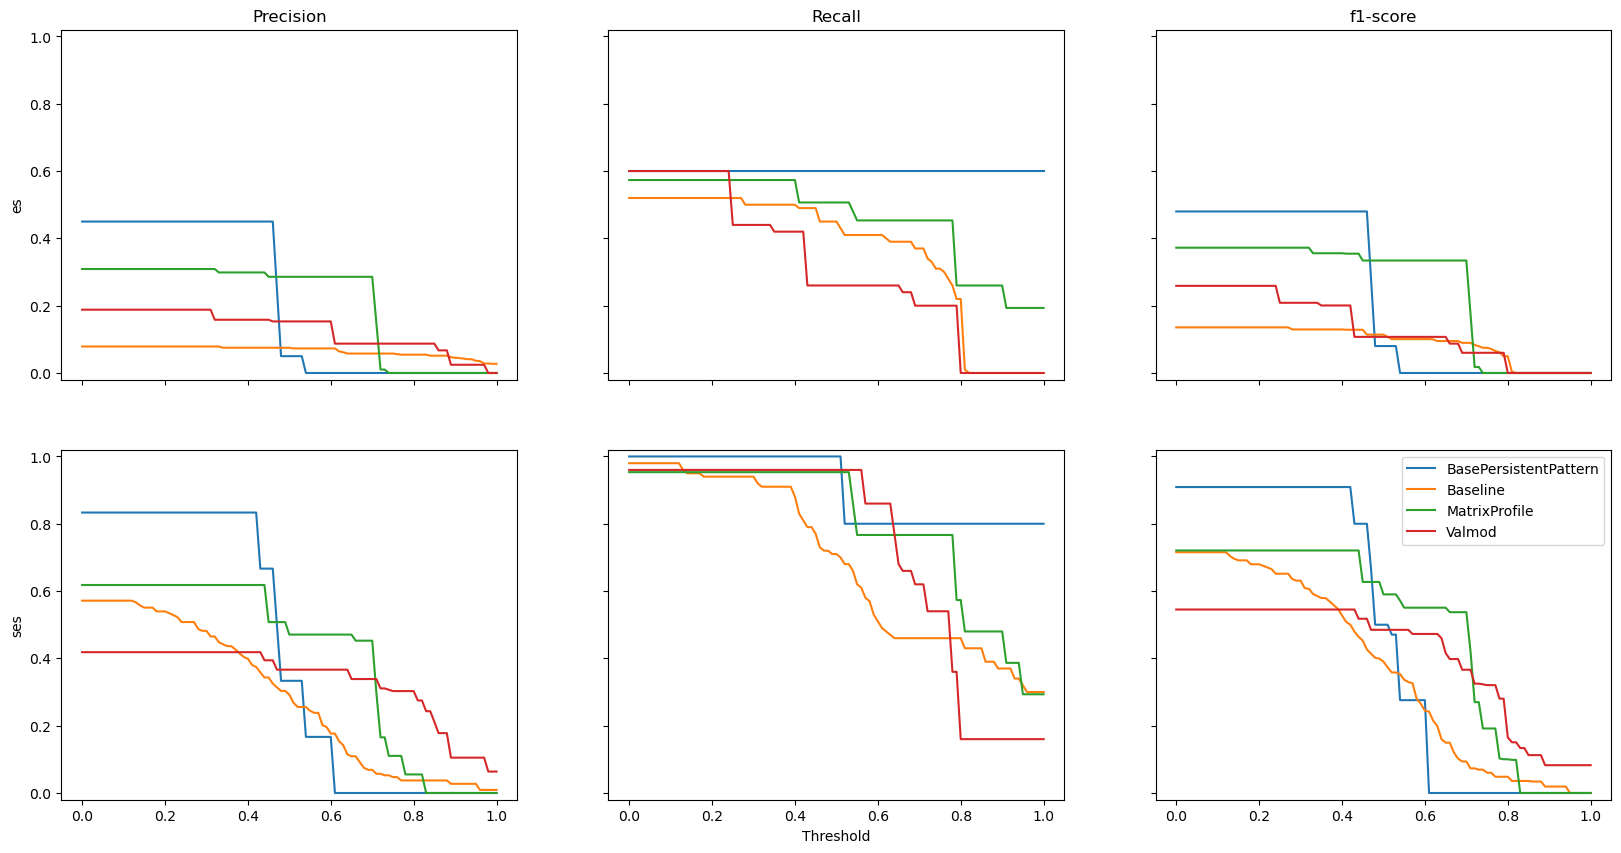

In [17]:
t_df = df[~df['metric'].isin(['ss', 'sss', 'es_auc', 'ses_auc'])].groupby(['metric','threshold','algorithm']).mean()
t_df = t_df[['precision','recall','f1-score']]
pt = t_df.stack().unstack(1)
t_df = t_df.reset_index()
metrics = t_df.metric.unique().tolist()
score_names = ['precision', 'recall', 'f1-score']

fig,axs = plt.subplots(2,3, figsize=(20,10),sharex=True, sharey=True)
for i in range(len(pt)): 
    line = pt.iloc[i]
    row = metrics.index(line.name[0])
    col = score_names.index(line.name[2])
    axs[row,col].plot(np.linspace(0,1,line.values.shape[0]),line.values,label = line.name[1])

axs[0,0].set_title('Precision')
axs[0,1].set_title('Recall')
axs[0,2].set_title('f1-score')

for i,metric in enumerate(metrics): 
    axs[i,0].set_ylabel(metric)
axs[0,0].set_ylim(-0.02,1.02)
axs[len(metrics)-1,1].set_xlabel('Threshold')


plt.legend()

In [18]:
pres = pt.iloc[0].values
recall = pt.iloc[1].values

pres_mp = pt.iloc[6].values
recall_mp = pt.iloc[7].values

In [19]:
pt.iloc[6]

threshold
0.00    0.308957
0.01    0.308957
0.02    0.308957
0.03    0.308957
0.04    0.308957
          ...   
0.96    0.000000
0.97    0.000000
0.98    0.000000
0.99    0.000000
1.00    0.000000
Name: (es, MatrixProfile, precision), Length: 101, dtype: float64

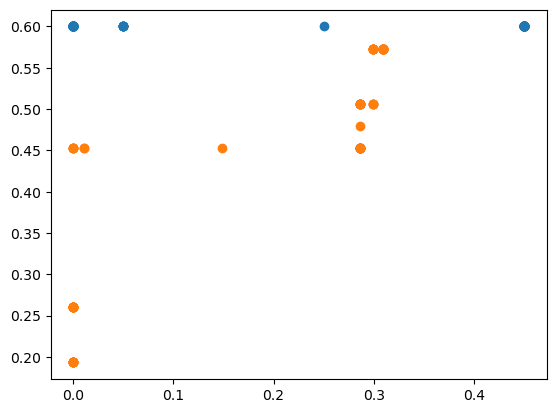

In [20]:
plt.scatter(pres,recall)
plt.scatter(pres_mp,recall_mp)


In [21]:
bpp = BasePersistentPattern(100,10,alpha=0.01,beta=0.,n_jobs=4)


In [22]:
df[df.metric == "ss"]

,metric,threshold,config_idx,score,precision,recall,f1-score,algorithm,signal_idx,ex_time
1,ss,NaN,0,NaN,0.224102,0.598529,0.316331,BasePersistentPattern,0,0.391544
217,ss,NaN,0,NaN,0.084364,0.307751,0.132215,Baseline,0,0.124398
218,ss,NaN,1,NaN,0.088428,0.351693,0.140979,Baseline,0,0.160089
219,ss,NaN,2,NaN,0.094467,0.434815,0.155068,Baseline,0,0.148905
220,ss,NaN,3,NaN,0.088617,0.438906,0.147247,Baseline,0,0.160082
221,ss,NaN,4,NaN,0.075336,0.441149,0.128513,Baseline,0,0.194468
222,ss,NaN,5,NaN,0.075104,0.453463,0.128303,Baseline,0,0.225349
223,ss,NaN,6,NaN,0.075594,0.516752,0.131528,Baseline,0,0.261820
224,ss,NaN,7,NaN,0.045397,0.356281,0.080479,Baseline,0,0.339811
225,ss,NaN,8,NaN,0.041057,0.308871,0.072290,Baseline,0,0.388948


In [23]:
df.to_dict(orient="record")

/var/folders/15/735bgx_91fgg0fvp4rvhj_6m0000gn/T/ipykernel_18405/1432459374.py:1: FutureWarning:

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.



[{'metric': 'sss',
  'threshold': nan,
  'config_idx': 0,
  'score': nan,
  'precision': 0.48687350835322196,
  'recall': 0.99836867862969,
  'f1-score': 0.6545454545454545,
  'algorithm': 'BasePersistentPattern',
  'signal_idx': 0,
  'ex_time': 0.3915438652038574},
 {'metric': 'ss',
  'threshold': nan,
  'config_idx': 0,
  'score': nan,
  'precision': 0.22410187872398474,
  'recall': 0.5985294117647059,
  'f1-score': 0.3163305232255925,
  'algorithm': 'BasePersistentPattern',
  'signal_idx': 0,
  'ex_time': 0.3915438652038574},
 {'metric': 'ses_auc',
  'threshold': nan,
  'config_idx': 0,
  'score': nan,
  'precision': 0.41749174917491755,
  'recall': 0.902970297029703,
  'f1-score': 0.47356224466260005,
  'algorithm': 'BasePersistentPattern',
  'signal_idx': 0,
  'ex_time': 0.3915438652038574},
 {'metric': 'ses',
  'threshold': 0.0,
  'config_idx': 0,
  'score': nan,
  'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1-score': 0.9090909090909091,
  'algorithm': 'BasePersistentPa

In [24]:
pdf = pd.DataFrame.from_dict(configs_mp)

In [25]:
np.repeat([i for i in range(15)],5)

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,
        3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10,
       10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13,
       13, 13, 14, 14, 14, 14, 14])

In [26]:
pdf.iloc[[1,1]]

,distance_name,n_jobs,n_patterns,radius_ratio,wlen
1,NormalizedEuclidean,4,3,1.285714,150
1,NormalizedEuclidean,4,3,1.285714,150
